In [1]:
import os
import time
from functools import reduce
from multiprocessing import cpu_count

import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             classification_report, confusion_matrix, f1_score,
                             make_scorer, matthews_corrcoef)
from sklearn.model_selection import (StratifiedKFold, cross_val_predict,
                                     cross_val_score, train_test_split)
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)

# Load data 


In [2]:
df = pd.read_csv('../data/dataset.csv')

In [3]:
df.head()

,gender,food_insecurity,food_insecurity_description,race,urbanization,urban_description,state,income,age,years_schooling,ate_ufp,is_male,region,is_caucasian,is_rural
0,M,3,insegurança moderada,branca,1,urbano,Paraíba,339.63,15,9,0,1,Nordeste,1,0
1,M,2,insegurança leve,branca,1,urbano,Piauí,252.01,16,9,0,1,Nordeste,1,0
2,F,1,seguranca alimentar,branca,1,urbano,Paraná,1072.54,72,5,0,0,Sul,1,0
3,F,1,seguranca alimentar,branca,1,urbano,Goiás,2806.49,50,5,0,0,Centro Oeste,1,0
4,M,1,seguranca alimentar,parda,2,rural,Ceará,738.59,54,4,0,1,Nordeste,0,1


In [4]:
df['Is non-white'] = df.is_caucasian.apply(lambda x: 0 if x == 1 else 1)
df['Is female'] = df.is_male.apply(lambda x: 0 if x == 1 else 1)

In [5]:
df.head()

,gender,food_insecurity,food_insecurity_description,race,urbanization,urban_description,state,income,age,years_schooling,ate_ufp,is_male,region,is_caucasian,is_rural,Is non-white,Is female
0,M,3,insegurança moderada,branca,1,urbano,Paraíba,339.63,15,9,0,1,Nordeste,1,0,0,0
1,M,2,insegurança leve,branca,1,urbano,Piauí,252.01,16,9,0,1,Nordeste,1,0,0,0
2,F,1,seguranca alimentar,branca,1,urbano,Paraná,1072.54,72,5,0,0,Sul,1,0,0,1
3,F,1,seguranca alimentar,branca,1,urbano,Goiás,2806.49,50,5,0,0,Centro Oeste,1,0,0,1
4,M,1,seguranca alimentar,parda,2,rural,Ceará,738.59,54,4,0,1,Nordeste,0,1,1,0


In [6]:
df.rename(columns = {
    'food_insecurity': 'Food insecurity level',
    'is_rural': 'Lives in rural area',
    'income': 'Per capita income',
    'years_schooling': 'Years of schooling',
    'age': 'Age',
    }, inplace=True)

In [7]:
df.head()

,gender,Food insecurity level,food_insecurity_description,race,urbanization,urban_description,state,Per capita income,Age,Years of schooling,ate_ufp,is_male,region,is_caucasian,Lives in rural area,Is non-white,Is female
0,M,3,insegurança moderada,branca,1,urbano,Paraíba,339.63,15,9,0,1,Nordeste,1,0,0,0
1,M,2,insegurança leve,branca,1,urbano,Piauí,252.01,16,9,0,1,Nordeste,1,0,0,0
2,F,1,seguranca alimentar,branca,1,urbano,Paraná,1072.54,72,5,0,0,Sul,1,0,0,1
3,F,1,seguranca alimentar,branca,1,urbano,Goiás,2806.49,50,5,0,0,Centro Oeste,1,0,0,1
4,M,1,seguranca alimentar,parda,2,rural,Ceará,738.59,54,4,0,1,Nordeste,0,1,1,0


In [8]:
df.ate_ufp.value_counts(normalize=True)

ate_ufp
0    0.6
1    0.4
Name: proportion, dtype: float64

In [10]:
df.ate_ufp.value_counts()

ate_ufp
0    927
1    618
Name: count, dtype: int64

# Test ML Models

In [11]:
# make a scorer of matthews correlation coefficient
mcc_scorer = make_scorer(matthews_corrcoef)

In [12]:
def train_models_with_cross_val_score(x, y, experiment_name, n_jobs=-1):
    """
    Function to train a selection of models using cross-validation and report their performance.
     
    Parameters:
    x: Features for training the model
    y: Labels for training the model
    experiment_name: Name of the experiment (useful for saving results)
    n_jobs: Number of CPU cores to use for parallel processing (default is -1, which uses all available cores)
    
    Returns:
    df_results: DataFrame containing model names and their respective scores
    creports: (currently empty) Could be used to store classification reports
    trained_models: (currently empty) Could be used to store trained models
    """

    if n_jobs == -1:
        n_jobs = cpu_count()

    # Initialize a list of models
    models = []
    clf_lr = LogisticRegression(random_state=314, n_jobs=cpu_count(), class_weight='balanced')
    clf_cat = CatBoostClassifier(random_state=314, silent=True)
    clf_vote = VotingClassifier(estimators=[('lr', clf_lr), ('cat', clf_cat)], voting='soft', n_jobs=cpu_count())

    models.append(('LR', LogisticRegression(random_state=314, n_jobs=n_jobs, class_weight='balanced')))
    models.append(('RF', RandomForestClassifier(random_state=314, n_jobs=n_jobs, class_weight='balanced')))
    models.append(('LGBM', lgb.LGBMClassifier(random_state=314, n_jobs=n_jobs, class_weight='balanced')))
    models.append(('XGB', XGBClassifier(random_state=314, n_jobs=n_jobs, class_weight='balanced')))
    models.append(('MLP', MLPClassifier(random_state=314)))
    models.append(('SGD', SGDClassifier(random_state=314, n_jobs=n_jobs, class_weight='balanced')))
    models.append(('SVC', SVC(random_state=314, class_weight='balanced')))
    models.append(('CATBOOST', CatBoostClassifier(random_state=314, silent=True)))
    
    models.append(('LSVC', LinearSVC(random_state=314, class_weight='balanced')))
    models.append(('KNN', KNeighborsClassifier(n_jobs=n_jobs)))
    models.append(('DT', DecisionTreeClassifier(random_state=314, class_weight='balanced')))
    models.append(('VOTE_LR_CATBOOST', clf_vote))

    results = []
    creports = [] # Placeholder list for classification reports (currently unused)
    trained_models = [] # Placeholder list for returning trained models (currently unused)
    mcc_scorer = make_scorer(matthews_corrcoef)  # Create MCC scorer to use in cross_val_score

    for name, model in models:
        start_time = time.time()

        scores = cross_val_score(
            estimator=model,
            X=x,
            y=y,
            cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=314),
            scoring=mcc_scorer
        )
        
        mcc_mean = scores.mean()
        results.append([experiment_name, name, mcc_mean, scores])
        print(f'Name: {name} - MCC_mean: {mcc_mean:.4f} - Scores: {scores}')

    df_results = pd.DataFrame(results, columns=['Experiment', 'Model', 'MCC_mean', 'MCC_scores'])

    return df_results, creports, trained_models


In [13]:
cat_feat = [] 
num_feat = ['Per capita income', 'Age', 'Years of schooling', 'Food insecurity level', 'Is non-white', 'Lives in rural area', 'Is female']
y_feat = ['ate_ufp']

data = df[cat_feat + num_feat + y_feat].copy()
data = pd.get_dummies(data, columns=cat_feat)

features = [c for c in data.columns if c not in y_feat]

x = data[features]
y = data[y_feat].values.ravel()



In [14]:
data[features]

,Per capita income,Age,Years of schooling,Food insecurity level,Is non-white,Lives in rural area,Is female
0,339.63,15,9,3,0,0,0
1,252.01,16,9,2,0,0,0
2,1072.54,72,5,1,0,0,1
3,2806.49,50,5,1,0,0,1
4,738.59,54,4,1,1,1,0
...,...,...,...,...,...,...,...
1540,801.70,24,12,2,1,0,1
1541,1499.66,38,16,2,1,0,1
1542,1997.35,43,12,2,1,0,0
1543,1997.35,41,12,2,1,0,1


In [15]:

scaler = StandardScaler()
x_tfm = scaler.fit_transform(x)
x_tfm = pd.DataFrame(x_tfm, columns=scaler.get_feature_names_out())
x_tfm

,Per capita income,Age,Years of schooling,Food insecurity level,Is non-white,Lives in rural area,Is female
0,-0.497409,-1.365272,0.191899,1.449052,-1.406015,-0.660207,-1.156446
1,-0.534568,-1.313094,0.191899,0.336336,-1.406015,-0.660207,-1.156446
2,-0.186582,1.608870,-0.666854,-0.776381,-1.406015,-0.660207,0.864718
3,0.548785,0.460956,-0.666854,-0.776381,-1.406015,-0.660207,0.864718
4,-0.328210,0.669667,-0.881542,-0.776381,0.711230,1.514676,-1.156446
...,...,...,...,...,...,...,...
1540,-0.301445,-0.895670,0.835964,0.336336,0.711230,-0.660207,0.864718
1541,-0.005441,-0.165179,1.694718,0.336336,0.711230,-0.660207,0.864718
1542,0.205629,0.095710,0.835964,0.336336,0.711230,-0.660207,-1.156446
1543,0.205629,-0.008646,0.835964,0.336336,0.711230,-0.660207,0.864718


In [16]:
df_results_cvs, creports_cvs, trained_models_cvs = train_models_with_cross_val_score(x_tfm, y, '1')

Name: LR - MCC_mean: 0.2247 - Scores: [0.2742012  0.22904766 0.23816526 0.18232201 0.1423737  0.22186433
 0.24236804 0.33439173 0.21751863 0.16451567]
Name: RF - MCC_mean: 0.2058 - Scores: [0.18878404 0.14898307 0.25354628 0.22942764 0.20835137 0.13086404
 0.23579927 0.1747613  0.27426621 0.21354058]
Name: LGBM - MCC_mean: 0.1980 - Scores: [0.34401648 0.11290323 0.24292763 0.16666667 0.09483672 0.19980972
 0.20607611 0.22993476 0.22460848 0.15867671]
[13:56:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1679035063795/work/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[13:56:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1679035063795/work/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[13:56:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1679035063795/work/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[13:56:13] WARNING: /home/conda/feedstock_root/build_art

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


Name: MLP - MCC_mean: 0.2397 - Scores: [0.29709715 0.24077171 0.20001384 0.27086817 0.17407766 0.17301592
 0.27418672 0.23843027 0.28594555 0.24285007]
Name: SGD - MCC_mean: 0.1314 - Scores: [ 0.15302205  0.18505611  0.08883955  0.02220989  0.1910865   0.22894184
  0.12604811 -0.05417822  0.11677925  0.25643107]
Name: SVC - MCC_mean: 0.2323 - Scores: [0.305585   0.28574024 0.18046343 0.12869789 0.16012815 0.16324967
 0.26705447 0.35200919 0.25009789 0.22993476]
Name: CATBOOST - MCC_mean: 0.2586 - Scores: [0.3380617  0.22691522 0.27913092 0.19153326 0.17763366 0.20947702
 0.27914202 0.27027422 0.30000438 0.31356834]


Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.


Name: LSVC - MCC_mean: 0.2308 - Scores: [0.2742012  0.22904766 0.23354091 0.18232201 0.1423737  0.23301646
 0.23762639 0.35634637 0.2332522  0.18610619]
Name: KNN - MCC_mean: 0.1406 - Scores: [ 0.20081983  0.02901294  0.06633581  0.20628425  0.14646252 -0.00567873
  0.21175045  0.21008952  0.12993797  0.21081389]
Name: DT - MCC_mean: 0.1302 - Scores: [0.16666667 0.00546228 0.23354091 0.19354839 0.02668803 0.0555135
 0.21725708 0.13303146 0.16304348 0.10752387]
Name: VOTE_LR_CATBOOST - MCC_mean: 0.2752 - Scores: [0.32444284 0.28745519 0.28745519 0.27674096 0.2007079  0.27963893
 0.33284714 0.27658139 0.23822324 0.24799513]


In [17]:
df_results_cvs.sort_values(by='MCC_mean', ascending=False)


,Experiment,Model,MCC_mean,MCC_scores
11,1,VOTE_LR_CATBOOST,0.275209,"[0.3244428422615251, 0.28745518828288574, 0.28..."
7,1,CATBOOST,0.258574,"[0.3380617018914066, 0.2269152152350059, 0.279..."
4,1,MLP,0.239726,"[0.29709715068170467, 0.2407717061715384, 0.20..."
6,1,SVC,0.232296,"[0.3055849957889679, 0.2857402366675567, 0.180..."
8,1,LSVC,0.230783,"[0.2742011987729442, 0.22904766000271254, 0.23..."
0,1,LR,0.224677,"[0.2742011987729442, 0.22904766000271254, 0.23..."
3,1,XGB,0.213486,"[0.2939126447265944, 0.1693306607139861, 0.231..."
1,1,RF,0.205832,"[0.18878403798495139, 0.14898306890404794, 0.2..."
2,1,LGBM,0.198046,"[0.3440164806162261, 0.11290322580645161, 0.24..."
9,1,KNN,0.140583,"[0.20081982829242623, 0.029012942659282972, 0...."


# Train Ensemble classifier and show SHAP values


In [18]:
clf_lr = LogisticRegression(random_state=314, n_jobs=cpu_count(), class_weight='balanced')
clf_cat = CatBoostClassifier(random_state=314, silent=True, thread_count=cpu_count())
clf_vote = VotingClassifier(estimators=[('lr', clf_lr), ('cat', clf_cat)], voting='soft', n_jobs=cpu_count())

clf_vote.fit(x_tfm, y)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(class_weight='balanced',
                                                 n_jobs=28, random_state=314)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x7f7f63a5bc70>)],
                 n_jobs=28, voting='soft')

In [19]:
# Explain in iteration n=K in summary
explainer = shap.explainers.Exact(clf_vote.predict, x_tfm)
shap_values = explainer(x_tfm)


Exact explainer: 1546it [01:02, 21.25it/s]                          


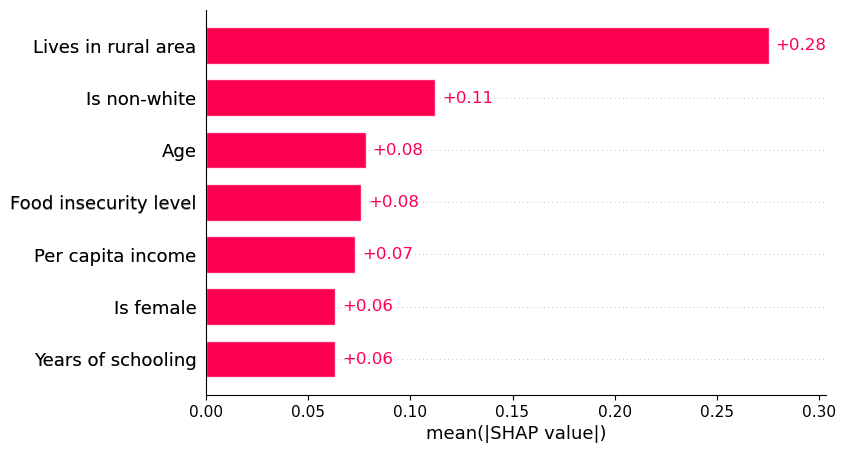

In [20]:
# save the plot with 300 dpi
shap.plots.bar(shap_values, show=False)
plt.savefig('../figures/shap_bar.png', dpi=300, bbox_inches='tight')
plt.show()


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


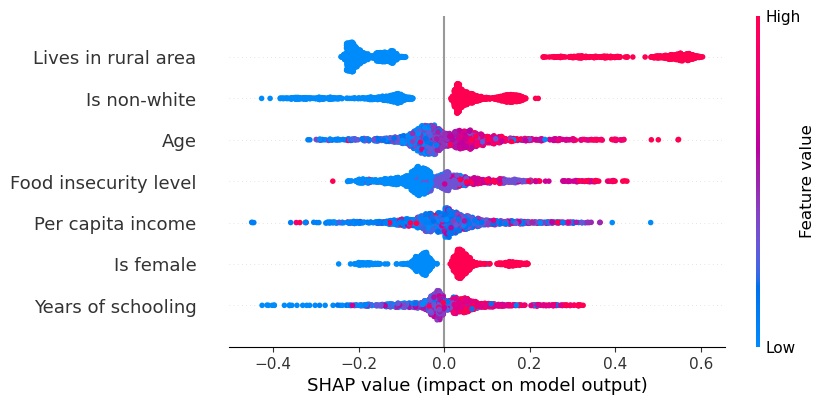

In [21]:
shap.plots.beeswarm(shap_values, show=False)
plt.savefig('../figures/shap_beeswarm.png', dpi=300, bbox_inches='tight')
plt.show()


# Tests for data visualization

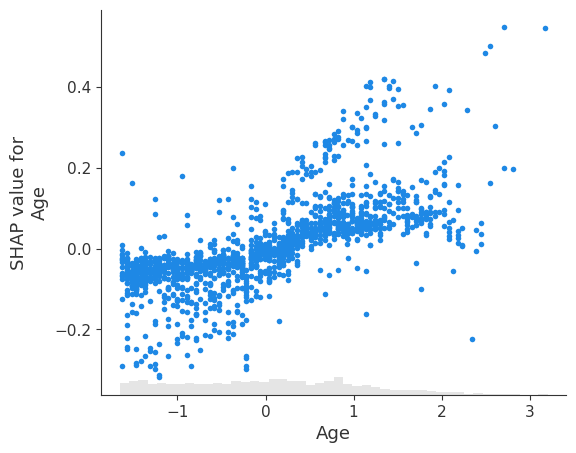

In [22]:
# Note that we are slicing off the column of the shap_values Explanation corresponding to the "Age" feature
shap.plots.scatter(shap_values[:,"Age"])

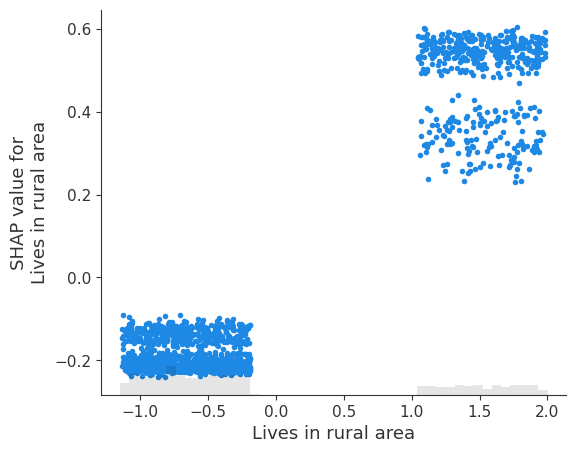

In [23]:
# Note that we are slicing off the column of the shap_values Explanation corresponding to the "Age" feature
shap.plots.scatter(shap_values[:,"Lives in rural area"])

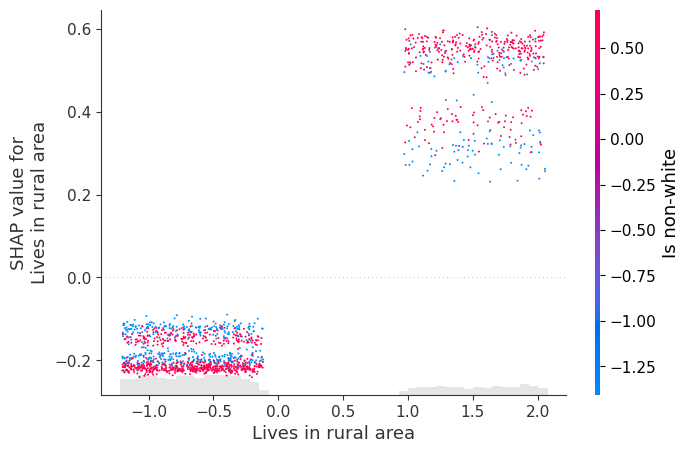

In [24]:
# Note that we are slicing off the column of the shap_values Explanation corresponding to the "Lives in rural area" feature
shap.plots.scatter(shap_values[:,"Lives in rural area"], dot_size=2, x_jitter=0.5, color=shap_values[:,"Is non-white"])

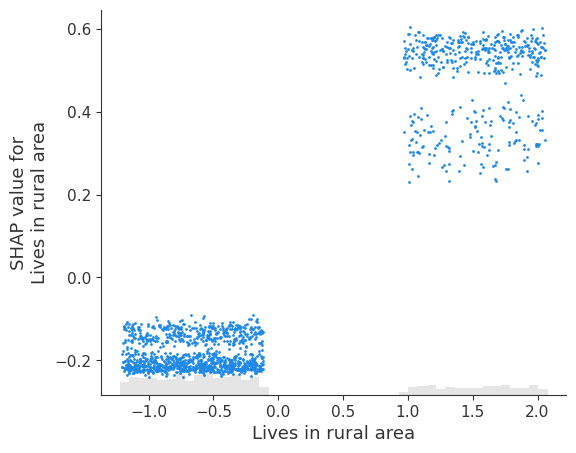

In [25]:
# Note that we are slicing off the column of the shap_values Explanation corresponding to the "Lives in rural area" feature
shap.plots.scatter(shap_values[:,"Lives in rural area"], dot_size=4, x_jitter=0.5)

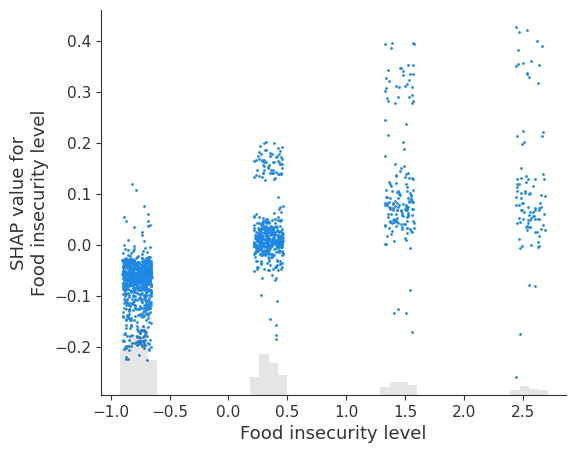

In [26]:
shap.plots.scatter(shap_values[:,"Food insecurity level"], dot_size=4)

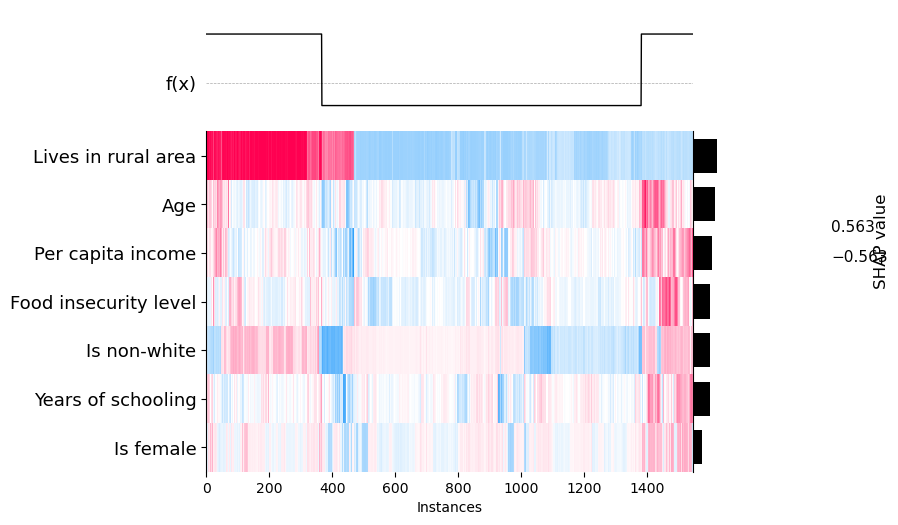

In [27]:
shap.plots.heatmap(shap_values, feature_values=shap_values.abs.max(0))

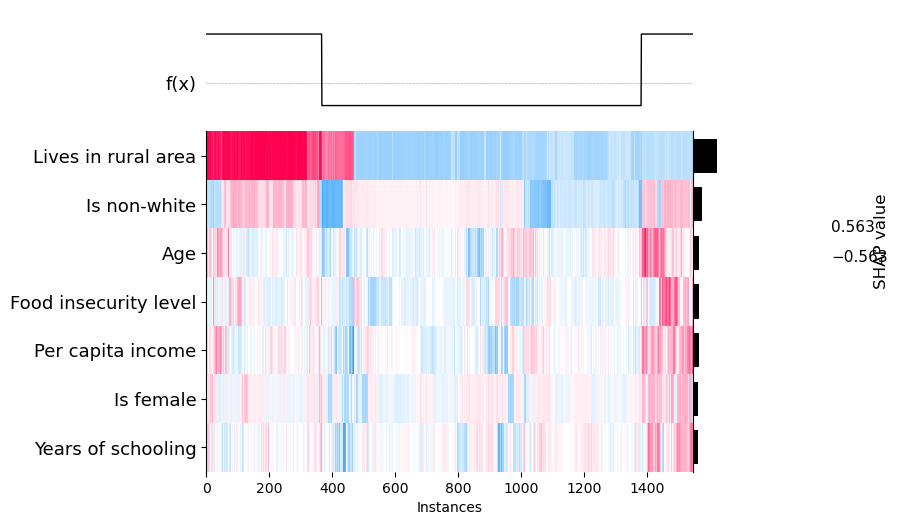

In [28]:
shap.plots.heatmap(shap_values)

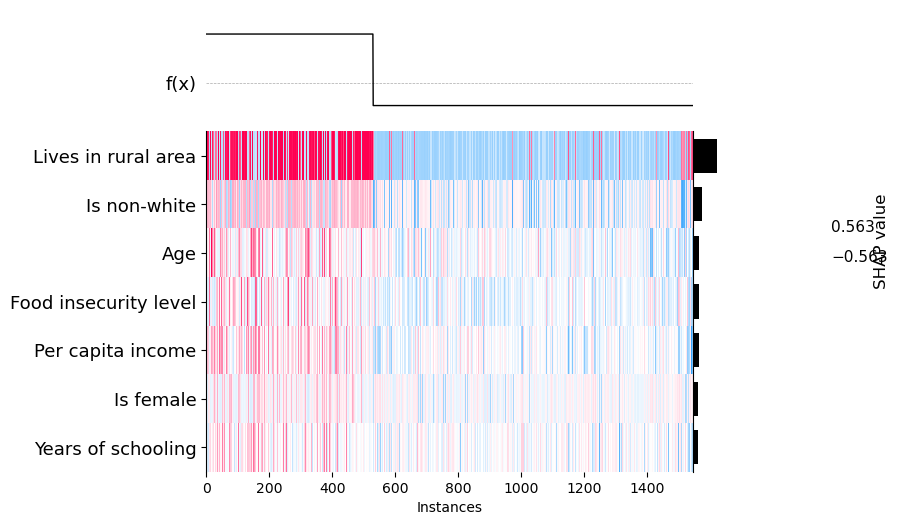

In [29]:
shap.plots.heatmap(shap_values, instance_order=shap_values.sum(1))

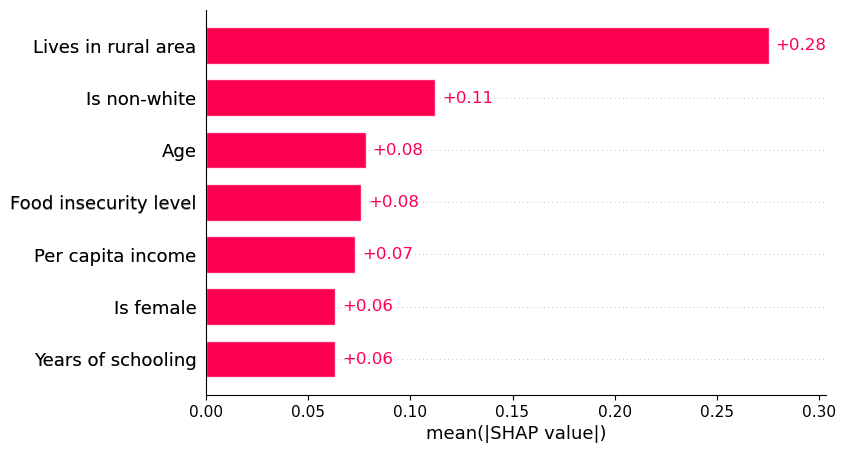

In [30]:
living_place = ["Lives in rural area" if shap_values[i,"Lives in rural area"].data == 1 else "Lives in urban area" for i in range(shap_values.shape[0])]
shap.plots.bar(shap_values.cohorts(living_place).abs.mean(0))

In [31]:
# get feature names from shap
feature_names = shap_values.feature_names
feature_names = [i for i in feature_names if i != "Lives in rural area"]
feature_names

['Per capita income',
 'Age',
 'Years of schooling',
 'Food insecurity level',
 'Is non-white',
 'Is female']

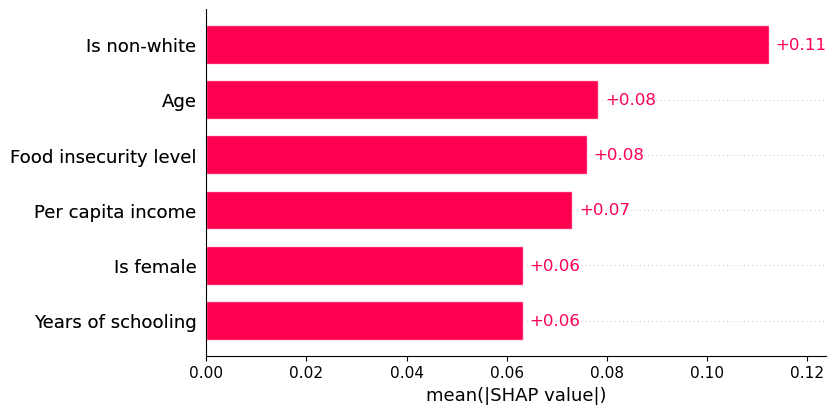

In [32]:
# slice all shap features, except Age
shap_values

living_place = ["Lives in rural area" if shap_values[i,"Lives in rural area"].data == 1 else "Lives in urban area" for i in range(shap_values.shape[0])]
shap.plots.bar(shap_values[:, feature_names].cohorts(living_place).abs.mean(0))


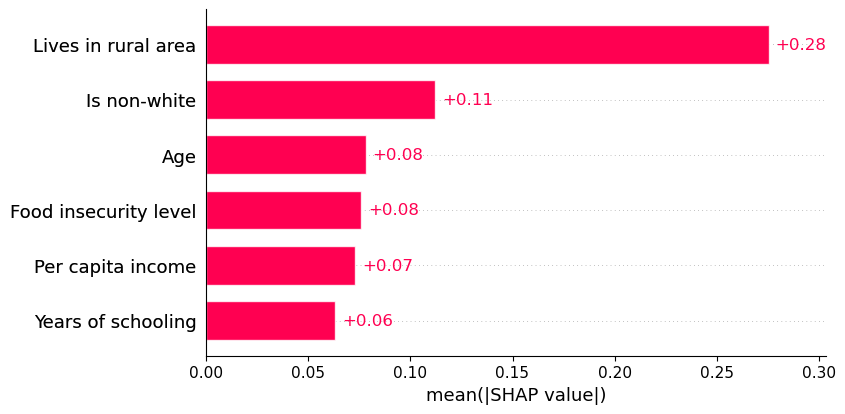

In [33]:
# slice all shap features, except Is Female
shap_values
feature_names = shap_values.feature_names
feature_names = [i for i in feature_names if i != "Is female"]

sex = ["Female" if shap_values[i,"Is female"].data == 1 else "Male" for i in range(shap_values.shape[0])]
shap.plots.bar(shap_values[:, feature_names].cohorts(sex).abs.mean(0))
